
# Representation learning: variational autoencoders

# Learning representations for handwritten digits

In the previous practical session, we looked at developing a deep learning pipeline for classifying blood cells as healthy of parasitized. The model we trained was an example of a discriminative model $p_\theta$, which uses samples from an unknown joint distribution $p(X,Y)$ to approximate $p(Y|X)$ as closely as possible. The optimal $p_{\theta^*}$ can then be used to make predictions.

In this session, we will look at generative models. These models use samples from an unknown data distribution $p_X$ to find the optimal $p_\theta$ that approximates $P_X$. The model $p_{\theta^*}$ can then be used to generate new samples from the approximated data distribution.

In particular, we will use a Variational Autoencoder to approximate the data distribution of handwritten digits. For this we will use the default computer vision dataset: MNIST.

This practical session is based on a [tutorial from the TensorFlow documentation](https://www.tensorflow.org/tutorials/generative/cvae).

# Setup

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import numpy as np
import seaborn
from matplotlib import cm
import pandas
import datetime

In [2]:
tf.random.set_seed(42)

In [3]:
from tensorflow.python.client import device_lib

def select_device(prefer_gpu=True):
    local_device_protos = device_lib.list_local_devices()
    gpus = [x.name for x in local_device_protos if x.device_type == 'GPU']
    if (len(gpus) > 0) and prefer_gpu:
        return gpus[0]
    else:
        return [x.name for x in local_device_protos if x.device_type == 'CPU'][0]

In [4]:
# This code sets the device to use to GPU if you have one available
device = select_device(prefer_gpu=True)
device

'/device:CPU:0'

# Load the MNIST dataset

We use the `tensorflow-datasets` package to load the MNIST dataset.

In [5]:
builder = tfds.builder('mnist')

In [6]:
builder.download_and_prepare()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


Look at some info about the dataset.

In [7]:
builder.info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/root/tensorflow_datasets/mnist/3.0.1.incomplete1KKJTV',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }"""

Use the builder to extract a TensorFlow Dataset for efficient access to the images.
We also split the dataset into training data for training the neural network parameters, and testing data for evaluating the network's performance on unseen data.

In [8]:
with tf.device(device):
    train_ds, test_ds = (
        builder.as_dataset(as_supervised=True, split="train"),
        builder.as_dataset(as_supervised=True, split="test")
    )

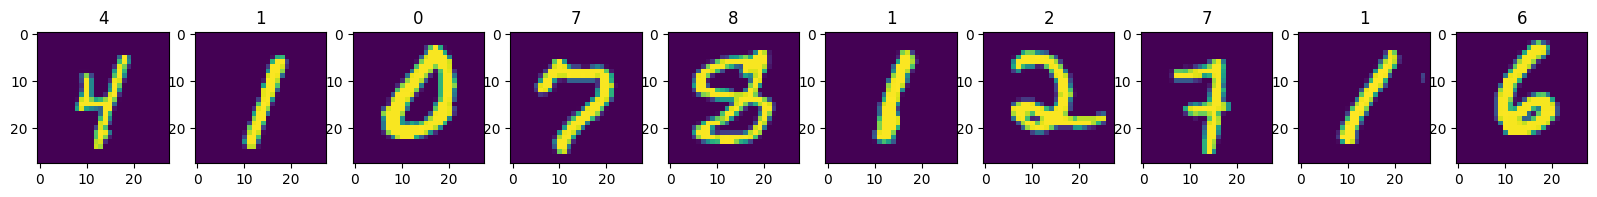

In [9]:
n_images = 10
fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100)
for ax, (image, label) in zip(axes, train_ds.take(n_images)):
    ax.imshow(image)
    ax.set_title(label.numpy())

# Preprocess the dataset

Eventhough we are only looking at black and white images of handwritten digits, $p_X$ is still quite a complex distribution to approximate. Therefore, we need to simplify the problem a little bit by thresholding the images.

This is done in two steps:
1. Normalize the pixel value range to [0,1].
2. Threshold all pixels at 0.5

In [10]:
# define the second preprocessing function
def normalization(image, label):
    return (image / 255, label)

def threshold(image, label):
    return (tf.where(image > 0.5, 1., 0.), label)

In [11]:
train_ds = train_ds.map(normalization)
test_ds = test_ds.map(normalization)

In [12]:
train_ds = train_ds.map(threshold)
test_ds = test_ds.map(threshold)

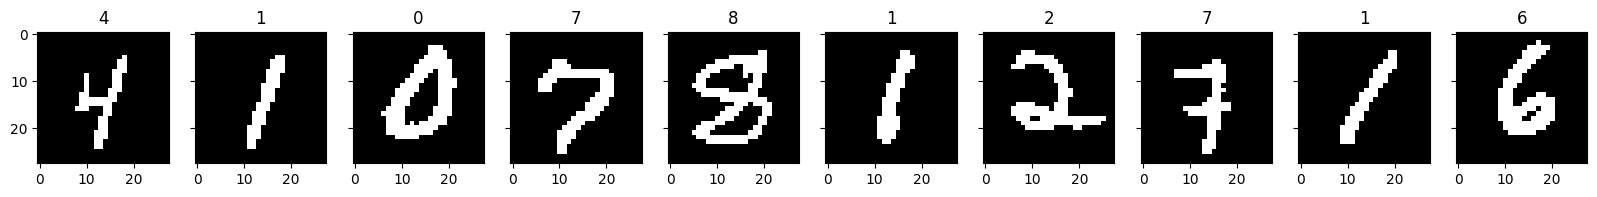

In [13]:
with tf.device(device):
    n_images = 10
    fig, axes = plt.subplots(1, n_images, figsize=(20, 5), dpi=100, sharex=True, sharey=True)
    for ax, (image, label) in zip(axes, train_ds.take(n_images)):
        ax.imshow(image[...,0], cmap="gray")
        ax.set_title(label.numpy())

In [14]:
with tf.device(device):
    train_ds = train_ds.shuffle(builder.info.splits["train"].num_examples)

The data is now preprocessed and ready to handled by the classifier that we will define in the next part.

# Define a variational autoencdoer architecture for representation learning

Since we are dealing with a computer vision task, we will use a **convolutional** variational autoencoder (CVAE). The CVAE has the same bottleneck structure as a standard variational autoencoder, but replaces the dense layers with convolutional and tranposed convolutional layers. The former type used in the encoder for down-sampling, and the latter in the decoder for upsampling. As with any autoencoder, the goal of the CVAE is to learn the *identity function*: learn to reconstruct the input image after "squeezing" it through a low-dimensional latent representation, also called the *bottleneck*.

Additionally, we will use a **variational** autoencoder for this task. This means we will use variational inference to find the optimal $\theta$ and $\lambda$ to parameterize, respectively, the decoder $p_\theta(x|z)$ and the encoder $q_\lambda(z|x)$, with $z$ the latent representation.

In order for us to be able to use $p_\theta(x|z)$, we need to first be able to choose a meaningfull $z$. Therefore, we will impose a Gaussian prior over $q_\lambda(z|x)$. We'll see how this is done when we define the loss

A high-level overview of the CVAE architecture is shown below:
![SegmentLocal](images/vae-gaussian.png "architecture")

### The reparameterization trick

The reparameterization trick is a very important part of the VAE. It allows us to learn a distribution over the random variable $Z$ (= the latent representation). Without the reparameterization trick, backpropagation would be stuck at the random bottleneck node. We cannot backpropagate through a random variable.

Therefore, we introduce a normally distributed random variable $\epsilon$ and we let the encoder output the parameters of a multivariate normal distribution as a vector. A latent representation for an input $x$ can then be constructed as follows:
1. Sample from $\epsilon\sim\mathcal{N}(O, \mathbb{1})$
2. $z = \mu + \sigma \odot \epsilon$

This $z$ can then be passed on to the decoder. The backpropagation can now flow through the parameter vector, that is output by the encoder.

**TASK 1**

Implement the reparameterization trick in the `reparameterize` function below.

**NOTE**:
We use the log-normal distribution for numerical stability during training. This means:

$$ \sigma = \sqrt{e^\textrm{logvar}} $$

In [15]:
image_width, image_height = 28,28

class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()

        subsampled_size = 7
        input_shape = (image_width, image_height, 1)

        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=input_shape),
              tf.keras.layers.Conv2D( # This layer will downsample the image to half its width and height
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D( # This layer will downsample the image again to half its current width and height
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )

        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=subsampled_size*subsampled_size*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(subsampled_size, subsampled_size, 32)),
              tf.keras.layers.Conv2DTranspose( # This layer will upsample the image to twice its current width and height
                  filters=64,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose( # This layer will upsample the image again to twice its current width and height
                  filters=32,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=input_shape[-1], kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs

        return logits

# The $\beta$-VAE loss function

As seen in the theory lecture on Representation learning, the end goal of training a variational auto-encoder is finding a model that approximates the data generating distribution $p_{data}$:

$$\theta*=\textrm{arg}\textrm{min}_{\theta\in\mathcal{M}}d(p_{data},p_\theta)$$

with $d$ the Kullback-Leibler divergence.

It can be shown that this minimization is equivalent to maximizing the log-likelihood $log{p_\theta}$ over a discrete dataset sampled from $p_{data}$. However, computing $log{p_\theta}$ is intractable due to the marginalization over $Z$, the latent random variable.

Therefore, we approximate this problem by maximizing a (tractable) lower-bound on $log{p_\theta}$, namely, the Evidence Lower BOund (ELBO):

$$\log p_\theta(x) \geq \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{\frac{p_\theta(x,z)}{q_\lambda(z|x)}}]$$

In order to be able to sample meaningful latent representations, we impose a unit Gaussian prior on $Z$.

This allows us to construct the VAE loss function:

$$\mathcal{L}(x; \theta, \lambda) = \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{p_\theta(x|z)}] - d_{KL}(q_\lambda(z|x), p_\theta(z))$$

By weighting the $d_{KL}$-term, we obtain the $\beta$-VAE loss function:

$$\mathcal{L}(x; \theta, \lambda, \beta) = \mathbb{E}_{z\sim q_\lambda(z|x)}[\log{p_\theta(x|z)}] - \beta*d_{KL}(q_\lambda(z|x), p_\theta(z))$$

Here, we approximate $\mathcal{L}(x; \theta, \lambda, \beta)$ using a single-sample Monte Carlo Estimate:

$$\log{p_\theta(x|z)} - \beta*(\log{q_\lambda(z|x)} - \log{p_\theta(z)})$$



**TASK 2**

Complete the missing parts in the function below to compute the loss.

In [16]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

In [17]:
@tf.function
def compute_loss(model, x_true, kl_weight=1):
    mu, logvar = model.encode(x_true) # parameters for the multivariate normal posterior
    z_sample = model.reparameterize(mu, logvar) # a sample from the posterior
    x_recons_logits = model.decode(z_sample) # the reconstruction of the sample

    raw_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=x_true,
                        logits=x_recons_logits)

    neg_log_likelihood = tf.math.reduce_sum(raw_cross_entropy, axis=[1, 2, 3])

    logpz = log_normal_pdf(z_sample, 0., 0.) # density of the prior evaluated at z_sample
    logqz_x = log_normal_pdf(z_sample, mu, logvar)  # density of the latent posterior evaluated at z_sample
    kl_divergence = logqz_x - logpz
    elbo = tf.math.reduce_mean(-kl_weight * kl_divergence - neg_log_likelihood)

    return dict(
        loss=-elbo,
        reconstruction=-neg_log_likelihood,
        kl=-kl_divergence
    )

In [18]:
@tf.function
def compute_apply_gradients(model, x, optimizer, kl_weight=1):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x, kl_weight=kl_weight)["loss"]
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Run learning procedure to train the network weights

Define some constants for the learning procedure.

In [19]:
epochs = 20
batch_size = 256

train_len = builder.info.splits["train"].num_examples
val_len = builder.info.splits["test"].num_examples
steps_per_epoch = train_len//batch_size
val_steps = val_len//batch_size

In [20]:
train_ds_batched = train_ds.batch(batch_size, drop_remainder=True)
test_ds_batched = test_ds.batch(batch_size, drop_remainder=True)

Next, we iteratively update the parameters of the network using mini-batches of data. Just like the model definition, the fitting procedure is slightly more verbose compared to the previous practical session. Again, we do this to accomodate for the extras required to correctly train the CVAE.

**TASK 3**

Now it is time to train the $\beta$-VAE.

First, create a CVAE model with 2 latent dimensions. Then, create an Adam optimizer with a learning rate of 0.001. Finally, implement the iterative training procedure.

Training pseudocode:
```
for every epoch
    for every batch in train dataset
        compute loss and apply gradients
        
    for every batch in test dataset
        compute loss
    
    print test set loss
```
Make sure to use the `compute_apply_gradients` and `compute_loss` functions. Set $\beta$ to 3.

In [21]:
latent_dim = 2
model = CVAE(latent_dim)

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [23]:
kl_weight = 3

with tf.device(device):
    for epoch in range(1, epochs+1):
        for i, (train_x,_) in enumerate(train_ds_batched):
            if i == steps_per_epoch:
                break
            compute_apply_gradients(model, train_x, optimizer, kl_weight)

        loss = tf.keras.metrics.Mean()
        for test_x,_ in test_ds_batched:
            loss(compute_loss(model, test_x, kl_weight=kl_weight)["loss"])

        elbo = -loss.result()
        print('Epoch {}, Test set ELBO {:.4f}'.format(epoch, elbo))

Epoch 1, Test set ELBO -191.2469
Epoch 2, Test set ELBO -183.3725
Epoch 3, Test set ELBO -176.8175
Epoch 4, Test set ELBO -172.2327
Epoch 5, Test set ELBO -168.8817
Epoch 6, Test set ELBO -167.3139
Epoch 7, Test set ELBO -166.2428
Epoch 8, Test set ELBO -165.4969
Epoch 9, Test set ELBO -164.6820
Epoch 10, Test set ELBO -164.2535
Epoch 11, Test set ELBO -163.7661
Epoch 12, Test set ELBO -163.2168
Epoch 13, Test set ELBO -162.9869
Epoch 14, Test set ELBO -162.7101
Epoch 15, Test set ELBO -162.2531
Epoch 16, Test set ELBO -162.1490
Epoch 17, Test set ELBO -162.1579
Epoch 18, Test set ELBO -162.0461
Epoch 19, Test set ELBO -161.8698


KeyboardInterrupt: ignored

# The latent representation

In the following section we have a look at the latent representation for the digits in the test set.

To do this, we simply feed images from the test set to the CVAE and record the $\mu$ and $\sigma$ for each one. We can then sample from the multivariate normal $\mathcal{N}(\mu, \sigma)$ to get a representation.

**TASK 4**

Complete the code below to inspect the latent representation.

In [24]:
z_means = np.empty((val_steps*batch_size, latent_dim), dtype=np.float32)
z_logvars = np.empty((val_steps*batch_size, latent_dim), dtype=np.float32)
z = np.empty((val_steps*batch_size, latent_dim))
labels = []

for i, (batch, l) in enumerate(test_ds_batched):
    m, lv = model.encode(batch) # use the model to get the multivariate normal paramters
    z_means[i*batch_size:(i+1)*batch_size] = m
    z_logvars[i*batch_size:(i+1)*batch_size] = lv

    z[i*batch_size:(i+1)*batch_size] = model.reparameterize(m, lv) # use the model to sample a latent vector

    labels.extend(l.numpy())

In [25]:
labels = np.array(labels)

Below, we plot a histogram for the mean and standard deviations returned by the model. What do you expect to see?

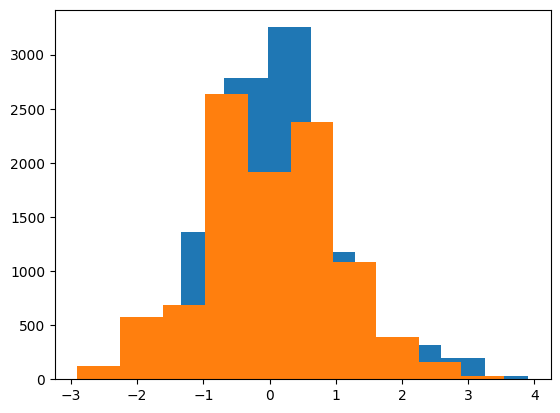

In [26]:
for i in range(latent_dim):
    plt.hist(z_means[:, i])

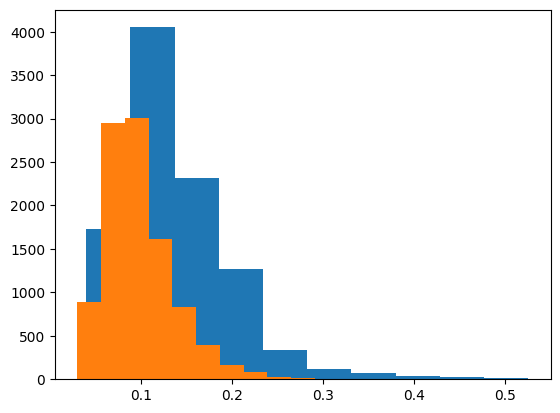

In [27]:
for i in range(latent_dim):
    plt.hist(np.sqrt(np.exp(z_logvars[:, i])))

Next, we plot the prior and posterior distributions over the latent representation.

Text(0.5, 1.0, 'Normal prior p(z)')

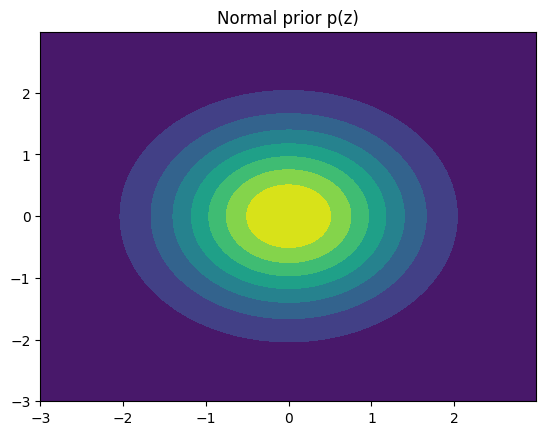

In [28]:
from scipy.stats import multivariate_normal
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
plt.contourf(x, y, rv.pdf(pos))
plt.title("Normal prior p(z)")

Below, we plot the average multivariate normal per digit.

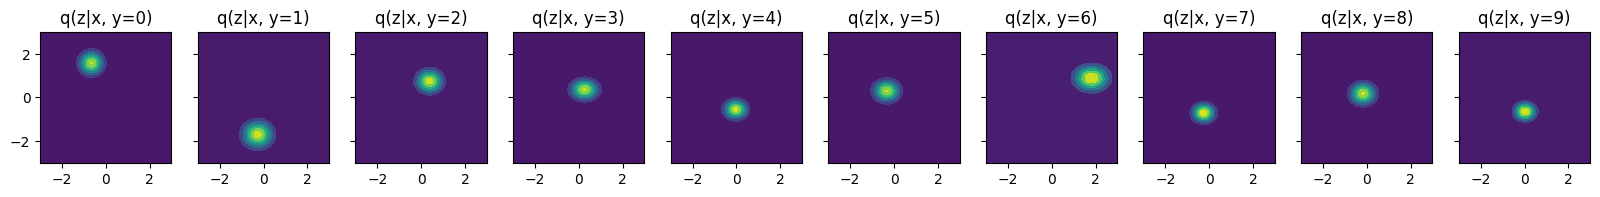

In [29]:
fig, axes = plt.subplots(1, len(np.unique(labels)), figsize=(20, 2), sharex=True, sharey=True)

for i, ax in enumerate(axes):
    rv = multivariate_normal(np.mean(z_means[np.nonzero(labels==i)], axis=0), np.eye(2)*np.mean(np.sqrt(np.exp(z_logvars[np.nonzero(labels==i)])), axis=0))
    ax.contourf(x, y, rv.pdf(pos))
    ax.set_title("q(z|x, y=%d)" % i)
    ax.set_aspect('equal')

Here, we plot the latent representation sampled from the normal latent posterior, colored according to ground truth label. Can you see the link between the plots above and the one below?

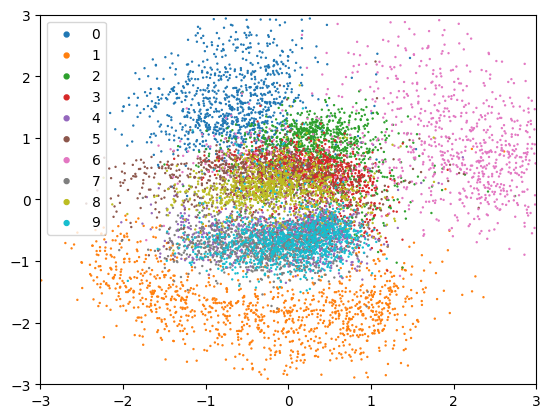

In [30]:
colors = np.array(list(map(lambda l: cm.tab10(l), labels)))

for i in np.unique(labels):
    plt.scatter(z[np.nonzero(labels==i), 0], z[np.nonzero(labels==i), 1], s=0.5, c=colors[np.nonzero(labels==i)], label=i)
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend(markerscale=5)

# Interpolation grid

In the final section we plot an *interpolation grid* by sampling from the data generating distribution $p_\theta(x|z)$ at points defined by the normal prior.

Note that we are able to choose meaningful latent embeddings, since we know that they are supposed to be distributed according to a unit normal.

Again, have a look at the interpolation grid and make the link to the multivariate normals per digit.

In [31]:
import tensorflow_probability as tfp

In [32]:
def plot_latent_images(model, n, digit_size=28):
    """Plots n x n digit images decoded from the latent space."""

    norm = tfp.distributions.Normal(0, 1)
    grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
    grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
    image_width = digit_size*n
    image_height = image_width
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_y[::-1]):
        for j, xi in enumerate(grid_x):
            z = np.array([[xi, yi]])
            x_decoded = model.sample(z)
            digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
            image[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit.numpy()

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()

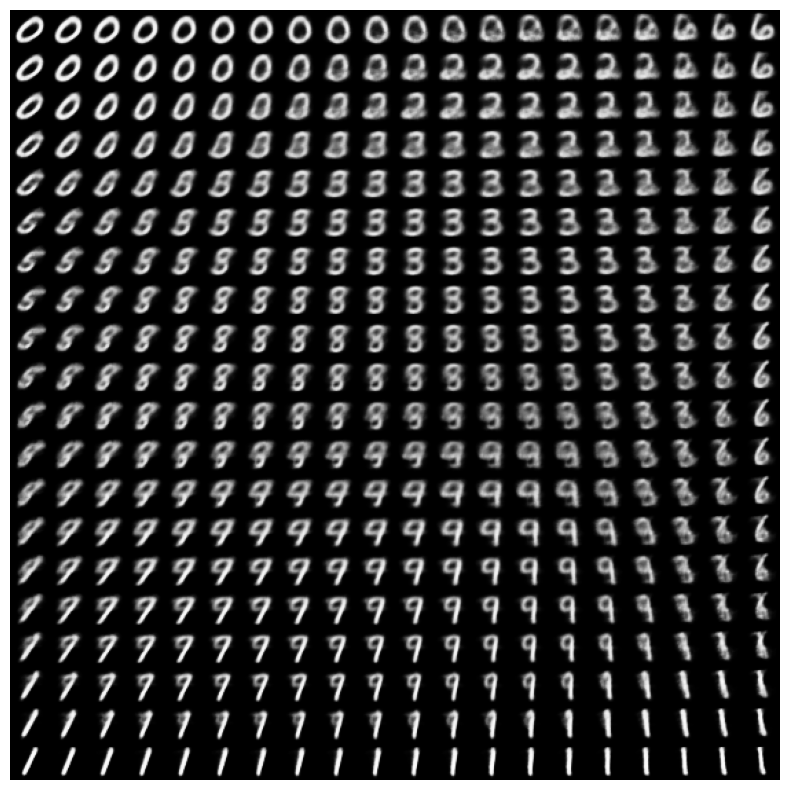

In [33]:
plot_latent_images(model, 20)